In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import seaborn as sns

# data precession
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score


# model
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_train_data():
    train = pd.read_csv('../input/train_2016_v2.csv')
#     train_2017 = pd.read_csv('input/train_2017.csv')
#     train = pd.concat([train_2016, train_2017], axis=0)
    
    properties = pd.read_csv('../input/properties_2016.csv')

    sample = pd.read_csv('../input/sample_submission.csv')
    sample = sample.rename(columns={'ParcelId': 'parcelid'})
    
    #train = train.merge(properties, on='parcelid', how='left')
    print(train.shape, properties.shape, sample.shape)
    
    return train, properties, sample

# Load data set
train_df, properties, sample_df = load_train_data()

(90275, 3) (2985217, 58) (2985217, 7)


In [3]:
count = props.isnull().sum()
ratio = count / len(props)
null_data = pd.concat([count,ratio],axis=1,keys=['count','ratio'])
null_data

,count,ratio
parcelid,0,0.000000
airconditioningtypeid,2173698,0.728154
architecturalstyletypeid,2979156,0.997970
basementsqft,2983589,0.999455
bathroomcnt,11462,0.003840
bedroomcnt,11450,0.003836
buildingclasstypeid,2972588,0.995769
buildingqualitytypeid,1046729,0.350637
calculatedbathnbr,128912,0.043183
decktypeid,2968121,0.994273


In [15]:
index = []
for i, v in enumerate(ratio):
    if v > 0.5:
        index.append(i)
        

In [6]:
props.drop(props.columns[index], axis = 1, inplace=True)

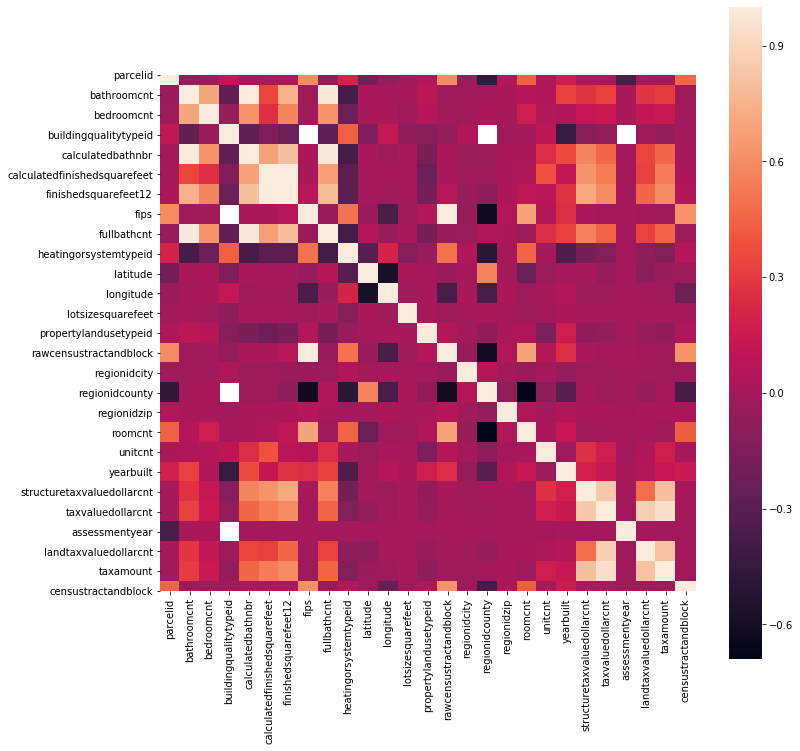

In [7]:
correlation = props.corr()
plt.subplots(figsize=(12, 12))
sns.heatmap(correlation, square=True)
plt.show()

Heatmap shows that 'bathroomcnt' and 'bedroomcnt',\
                   'calculatedbathnbr', 'calculatedfinishedsquarefeet' and 'finishedsquarefeet12'\
                   'structuretaxvaluedollarcnt' and 'taxvaluedollarcnt'\
                   'landtaxvaluedollarcnt' and 'taxmount' have high correlation.                   

In [7]:
properties.shape

(2985217, 29)

In [13]:
# # Add feature
# props['citycode'] = props['propertycountylandusecode'].apply(lambda x: str(x)[0:3])
# lbl = LabelEncoder()
# lbl.fit(list(props['citycode'].values))
# props['citycode'] = lbl.transform(list(props['citycode'].values))

# props['livingareaerror'] = props['calculatedfinishedsquarefeet'] / props['finishedsquarefeet12']

# properties['livingareaprop'] = properties['calculatedfinishedsquarefeet'] / properties['lotsizesquarefeet']

# properties['extraspace'] = properties['lotsizesquarefeet'] - properties['calculatedfinishedsquarefeet']

# properties['life'] = 2019 - properties['yearbuilt']

# properties['totalrooms'] = properties['bathroomcnt'] + properties['bedroomcnt']

# properties['averageroomsize'] = properties['calculatedfinishedsquarefeet'] / properties['roomcnt']

# properties['extrarooms'] = properties['roomcnt'] - properties['totalrooms']

# properties['valueproportion'] = properties['structuretaxvaluedollarcnt'] / properties['landtaxvaluedollarcnt']

# properties["location1"] = properties["latitude"] + properties["longitude"]

# properties["location2"] = properties["latitude"] * properties["longitude"]

# properties['taxratio'] = properties['taxvaluedollarcnt'] / properties['taxamount']

# zip_count = properties['regionidzip'].value_counts().to_dict()
# properties['zipcount'] = properties['regionidzip'].map(zip_count)

# city_count = properties['regionidcity'].value_counts().to_dict()
# properties['citycount'] = properties['regionidcity'].map(city_count)

# region_count = properties['regionidcounty'].value_counts().to_dict()
# properties['countycount'] = properties['regionidcounty'].map(region_count)

In [ ]:
# Add feature
props['citycode'] = props['propertycountylandusecode'].apply(lambda x: str(x)[0:3])
lbl = LabelEncoder()
lbl.fit(list(props['citycode'].values))
props['citycode'] = lbl.transform(list(props['citycode'].values))

props['livingareaerror'] = props['calculatedfinishedsquarefeet'] / props['finishedsquarefeet12']

props['livingareaprop'] = props['calculatedfinishedsquarefeet'] / props['lotsizesquarefeet']

props['extraspace'] = props['lotsizesquarefeet'] - props['calculatedfinishedsquarefeet']

props['life'] = 2019 - props['yearbuilt']

props['totalrooms'] = props['bathroomcnt'] + props['bedroomcnt']

props['averageroomsize'] = props['calculatedfinishedsquarefeet'] / props['roomcnt']

props['extrarooms'] = props['roomcnt'] - props['totalrooms']

props['valueproportion'] = props['structuretaxvaluedollarcnt'] / props['landtaxvaluedollarcnt']

props["location1"] = props["latitude"] + props["longitude"]

props["location2"] = props["latitude"] * props["longitude"]

props['taxratio'] = props['taxvaluedollarcnt'] / props['taxamount']

zip_count = props['regionidzip'].value_counts().to_dict()
props['zipcount'] = props['regionidzip'].map(zip_count)

city_count = props['regionidcity'].value_counts().to_dict()
props['citycount'] = props['regionidcity'].map(city_count)

region_count = props['regionidcounty'].value_counts().to_dict()
props['countycount'] = props['regionidcounty'].map(region_count)

In [14]:
properties.shape

(2985217, 44)

In [16]:
feature_names = properties.columns.tolist()

In [17]:
feature_names

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'calculatedfinishedsquarefeet',
 'finishedsquarefeet12',
 'fips',
 'fullbathcnt',
 'heatingorsystemtypeid',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'roomcnt',
 'unitcnt',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'assessmentyear',
 'landtaxvaluedollarcnt',
 'taxamount',
 'censustractandblock',
 'citycode',
 'livingareaerror',
 'livingareaprop',
 'extraspace',
 'life',
 'totalrooms',
 'averageroomsize',
 'extrarooms',
 'valueproportion',
 'location1',
 'location2',
 'taxratio',
 'zipcount',
 'citycount',
 'countycount']

In [ ]:
['pooltypeid10',
 'pooltypeid10',
 'buildingclasstypeid',
 'finishedsquarefeet13',
 'basementsqft',
 'storytypeid',
 'yardbuildingsqft26',
 'architecturalstyletypeid',
 'typeconstructiontypeid',
 'finishedsquarefeet6',
 'decktypeid',
 'pooltypeid10',
 'taxdelinquencyyear',
 'yardbuildingsqft17',
 'finishedsquarefeet15',
 'finishedfloor1squarefeet',
 'finishedsquarefeet50']

In [10]:
# train = train_df.merge(properties, on='parcelid', how='left')
# test = sample_df.merge(properties, on='parcelid', how='left')
# train = train[train.logerror > -0.4]
# train = train[train.logerror < 0.42]
# drop_feature = ['parcelid', 'logerror', 'transactiondate']

# x_train = train.drop(drop_feature, axis=1)
# y_train = train['logerror'].values
# x_test = test[x_train.columns]

In [11]:
# xgb_params = {}
# xgb_params['n_estimators'] = 250
# xgb_params['min_child_weight'] = 12
# xgb_params['learning_rate'] = 0.03
# xgb_params['max_depth'] = 10
# xgb_params['subsample'] = 0.8
# xgb_params['reg_lambda'] = 0.8
# xgb_params['reg_alpha'] = 0.4
# xgb_params['base_score'] = 0
# xgb_params['silent'] = 1

# param_test = {
#     'n_estimators': range(30, 50, 2),
#     'max_depth': range(2, 7, 1)
# }

# xgb_model = XGBRegressor(xgb_params)
# grid_xgb = GridSearchCV(estimator=xgb_model, param_grid = param_test,scoring='neg_mean_absolute_error', cv=5)
# grid_xgb.fit(x_train, y_train)
# grid_xgb.grid_scores_, grid_xgb.best_params_, grid_xgb.best_score_

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields propertycountylandusecode, propertyzoningdesc